In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random

In [2]:
DATA_DIR = "../data/"

In [3]:
sentences = np.load(os.path.join(DATA_DIR,"processed_sents_dl.npy"),allow_pickle=True)

In [4]:
tags = np.load(os.path.join(DATA_DIR,"processed_tags_dl.npy"),allow_pickle=True)

In [5]:
pos = np.load(os.path.join(DATA_DIR,"pos_dl.npy"),allow_pickle=True)

Here is what I did in this notebook:
1. I use the sentences and tags. 
2. I use data sampling since there a class imbalance problem. I consider only the sentences that contain BIO tags other than 'O'. This ensured I have all tags other than 'O' and my 'O' tags were greatly reduced.
3. I create a dictionary mapping every word to an index and every BIO tag to an index because I need to represent a sentence as a list of numbers for the LSTM.
4. I map every sentence using the above mapping.
5. I perform padding so that every sentence in the training data is of equal length.
6. I use glove embeddings to represent every word.
7. I use those in my embedding layer and set it to trainable.
8. It is followed by a bi-directional LSTM layer.
9. It is followed by a dense layer.
10. I use sparse categorical cross entropy loss to train the model.
11. I use Adam optimizer with an adaptive learning rate that decreases as we train the model for more epochs, to train a model.
12. I had to experiment with a decreasing learning rate as we train the model more and also different dimensions of Glove vectors. Finally I found out that the 100 dimensional glove vector provided the best result.


Some ideas taken from https://medium.com/analytics-vidhya/ner-tensorflow-2-2-0-9f10dcf5a0a

In [6]:
#from the processed data I only consider sentences that contain BIO tags other than 'O'. 
#this function will perform sampling as above
def sample_O(sentences,tags,Osleft):
    #array to store the sampled sentences and its corresponding tags
    newSentences=[]
    newTags=[]
    for i,sentence in enumerate(sentences):
        tag=tags[i]
        temp=tag.count('O')
        #if the number of 'O's in the labels for a sentence==len(tag) then it means it is a sentence containing only 'O' as
        #its labels. So skip it.
        if temp==len(tag):
            continue
        else:
            newSentences.append(sentence)
            newTags.append(tag)
            Osleft-=temp
            
    return newSentences,newTags
        

In [7]:
#function to count the number of labels of each type
def count_labels(tags):
    count={}
    for tag in tags:
        for word_label in tag:
            try:
                count[word_label]+=1
            except:
                count[word_label]=1
                
    return count

count = count_labels(tags)
print(count)

#variable to count the number of labels other than 'O'
otherThanO=0

for k,v in count.items():
    otherThanO+=v
    
otherThanO-=count['O']

print(otherThanO)
#sample sentences such that  only the sentences that contain BIO tags other than 'O' are considered. 
#This ensured I have all tags other than 'O' and my 'O' tags were greatly reduced.
sentences,tags=sample_O(sentences,tags,otherThanO)

{'O': 43672, 'B-location': 516, 'I-location': 230, 'B-group': 245, 'B-corporation': 213, 'B-creative-work': 130, 'B-product': 126, 'B-person': 631, 'I-person': 321, 'I-creative-work': 182, 'I-corporation': 40, 'I-group': 141, 'I-product': 156}
2931


In [8]:
#finally we have the following in our sampled data
print(count_labels(tags))

{'O': 15217, 'B-location': 516, 'I-location': 230, 'B-group': 245, 'B-corporation': 213, 'B-creative-work': 130, 'B-product': 126, 'B-person': 631, 'I-person': 321, 'I-creative-work': 182, 'I-corporation': 40, 'I-group': 141, 'I-product': 156}


In [9]:
assert len(sentences)==len(tags)

In [10]:
#the number of sentences we have
samples = len(sentences)

In [11]:
#get all unique BIO labels and words

#set to store all unique labels
labelSet = set()

#set to store all unique words
wordSet = set()

#iterate over all samples and store unique words and BIO labels
for i in range(samples):
    
    sentence,tag=sentences[i],tags[i]
    
    assert len(sentence)==len(tag)
    
    for i,word in enumerate(sentence):
        labelSet.add(tag[i])
        wordSet.add(word)

In [12]:
'''
Create a word to idx and label to idx mapping for the LSTM I implemented
 Assign index 0 for ‘PADDING_TOKEN’ and 1 for ‘UNKNOWN_TOKEN’. 
 ‘PADDING_TOKEN’ is used for token at the end of a sentence when one batch has sentences of unequal lengths. 
 ‘UNKNOWN_TOKEN’ is used to represent any word that is not present in the vocabulary.
'''

# Sort the set by length ensure '0' is assigned to O
sorted_labels = sorted(list(labelSet), key=len)

# Create mapping for labels
label2Idx = {}

for label in sorted_labels:
    label2Idx[label] = len(label2Idx)

#reverse mapping from idx to label
idx2Label = {v: k for k, v in label2Idx.items()}

# Create mapping for words
word2Idx = {}


#assing the PADDING_TOKEN and UNKNOWN_TOKEN first
if len(word2Idx) == 0:
    word2Idx["PADDING_TOKEN"] = len(word2Idx)
    word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
    
for word in wordSet:
    word2Idx[word] = len(word2Idx)
    
#reverse mapping from word to idx
idx2Word = {v: k for k, v in word2Idx.items()}

In [14]:
import pickle
with open('../data/word2Idx.pickle', 'wb') as handle:
    pickle.dump(word2Idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/idx2Word.pickle', 'wb') as handle:
    pickle.dump(idx2Word, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/label2Idx.pickle', 'wb') as handle:
    pickle.dump(label2Idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/idx2Label.pickle', 'wb') as handle:
    pickle.dump(idx2Label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
#function to map the sentence and tag to their correspond ids from the dictionaries created above
def map_to_idx(sentence, tag):
    sentenceToIdx=[]
    labelsToIdx=[]
    
    for i,word in enumerate(sentence):
        if word in word2Idx:
            wordIdx = word2Idx[word]
        elif word.lower() in word2Idx:
            wordIdx = word2Idx[word.lower()]
        else:
            wordIdx = word2Idx['UNKNOWN_TOKEN']

        sentenceToIdx.append(wordIdx)
        labelsToIdx.append(label2Idx[tag[i]])
        
    return sentenceToIdx, labelsToIdx

In [14]:
#create the dataset by mapping words and tags to the ids
X = []
y = []
for i in range(samples):
    
    sentence,tag=sentences[i],tags[i]
    sentenceToIdx, labelsToIdx = map_to_idx(sentence, tag)
    X.append(sentenceToIdx)
    y.append(labelsToIdx)

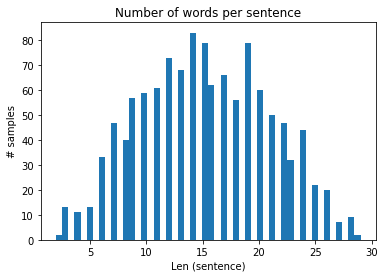

In [15]:

# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Number of words per sentence')
plt.xlabel('Len (sentence)')
plt.ylabel('# samples')
plt.show()

In [16]:
#based on the above graph I decided setting the max sentence length to 25 is a good idea

def padding(X,y, max_len, padding='post'):
    padded_sentences = pad_sequences(X, max_len,padding='post')
    padded_labels = pad_sequences(y, max_len, padding='post')
    return padded_sentences, padded_labels


X,y = padding(X,y, 25, padding='post')

In [17]:
#sanity check that we have the done the mapping right and created the right dataset
i=100
#print(X[i])
#print(y[i])
print(sentences[i])
print(tags[i])

print([idx2Word[w] for w in X[i]])
print([idx2Label[w] for w in y[i]])

['dude', 'i', 'can', 'watch', 'jennifers', 'body', 'i', 'know', 'what', 'imma', 'be', 'doing', 'all', 'week', 'xd', 'i', 'love', 'these', 'movies']
['O', 'O', 'O', 'O', 'B-creative-work', 'I-creative-work', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['dude', 'i', 'can', 'watch', 'jennifers', 'body', 'i', 'know', 'what', 'imma', 'be', 'doing', 'all', 'week', 'xd', 'i', 'love', 'these', 'movies', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN', 'PADDING_TOKEN']
['O', 'O', 'O', 'O', 'B-creative-work', 'I-creative-work', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=98)

In [20]:
#(number of sentences,length of each sentence)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(896, 25)
(299, 25)
(896, 25)
(299, 25)


In [21]:
EMBEDDING_DIM=300
BATCH = 32
max_seq_len = 25
num_labels = len(label2Idx)

In [22]:
# Loading glove embeddings
embeddings_index = {}
f = open("../embeddings/glove.6B.300d.txt", encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0] # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') #50d vectors   
    #representing the word
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((len(word2Idx), EMBEDDING_DIM))
# Word embeddings for the tokens


for word,i in word2Idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [24]:
train_dataset = train_dataset.batch(BATCH)
valid_dataset = valid_dataset.batch(BATCH)

In [25]:
#define the model which has the following architecture
#Embedding->BiLSTM->Dense
class NERmodel(tf.keras.Model):
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, num_labels, weights):

        super(NERmodel, self).__init__() 
        self.embedding = layers.Embedding(input_dim=embed_input_dim,
                                          output_dim=embed_output_dim, weights=weights,
                                          input_length=max_seq_len, trainable=True, mask_zero=True)        

        self.bilstm = layers.Bidirectional(layers.LSTM(512,return_sequences=True))
        #self.dense = layers.Dense(num_labels)
        self.dense = layers.Dense(num_labels)

    def call(self, inputs):

        x = self.embedding(inputs) # batchsize, max_seq_len,embedding_output_dim
        x = self.bilstm(x) #batchsize, max_seq_len, hidden_dim_bilstm
        logits = self.dense(x) #batchsize, max_seq_len, num_labels
        return logits

In [26]:
model = NERmodel(max_seq_len=max_seq_len,embed_input_dim=len(word2Idx), embed_output_dim=EMBEDDING_DIM, weights=[embedding_matrix], num_labels=num_labels)

#define the learning rate schedule, optimizer and loss function
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [27]:
#uncomment in case a previous model training is to be resumed
#model.load_weights(f"../models/best-lstm-v8")

In [28]:

#function defining one step of gradient descent on a given batch
def train_step_fn(sentences_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits = model(sentences_batch)
        loss = scce(labels_batch, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(list(zip(grads,model.trainable_variables)))
    return loss, logits

#evaluate the model on the one batch in the validation dataset
def valid_step_fn(sentences_batch, labels_batch):
    logits = model(sentences_batch)
    loss = scce(labels_batch, logits)
    return loss, logits


#variable to decide whether to save the model in the current iteration. If the model has the least validation loss uptil that 
#training step, save it.
min_val_loss=float('inf')

for epoch in range(200):
    
    #list to store the training and validation loss for this epoch
    training_loss=[]
    val_loss = []
    
    #perform one epoch on the training data
    for sentences_batch, labels_batch in train_dataset :
        loss, logits = train_step_fn(sentences_batch, labels_batch)
        training_loss.append(loss)
        
    #evaluate the model on the validation set
    for sentences_batch, labels_batch in valid_dataset:
        loss, logits = valid_step_fn(sentences_batch, labels_batch)
        val_loss.append(loss)
        
    
    curr_val_loss = sum(val_loss)/len(val_loss)
    print("Epoch",epoch)    
    print("Training loss %.4f"%(sum(training_loss)/len(training_loss)))
    print("Validation loss %.4f"%(curr_val_loss))
    
    if curr_val_loss<min_val_loss:
        print("Saving model...")
        model.save_weights(f"../models/best-lstm-v9",save_format='tf')
        min_val_loss=curr_val_loss
        
    print("\n")
    
    


Epoch 0
Training loss 1.4986
Validation loss 1.4263
Saving model...


Epoch 1
Training loss 1.2781
Validation loss 1.3153
Saving model...


Epoch 2
Training loss 1.1753
Validation loss 1.2663
Saving model...


Epoch 3
Training loss 1.0965
Validation loss 1.2367
Saving model...


Epoch 4
Training loss 1.0272
Validation loss 1.2308
Saving model...


Epoch 5
Training loss 0.9760
Validation loss 1.2343


Epoch 6
Training loss 0.9362
Validation loss 1.2558


Epoch 7
Training loss 0.9068
Validation loss 1.2249
Saving model...


Epoch 8
Training loss 0.8745
Validation loss 1.2084
Saving model...


Epoch 9
Training loss 0.8452
Validation loss 1.1930
Saving model...


Epoch 10
Training loss 0.8203
Validation loss 1.1912
Saving model...


Epoch 11
Training loss 0.7986
Validation loss 1.1925


Epoch 12
Training loss 0.7798
Validation loss 1.1908
Saving model...


Epoch 13
Training loss 0.7607
Validation loss 1.1831
Saving model...


Epoch 14
Training loss 0.7412
Validation loss 1.1673
Saving mode

Epoch 122
Training loss 0.0512
Validation loss 0.5639


Epoch 123
Training loss 0.0502
Validation loss 0.5656


Epoch 124
Training loss 0.0493
Validation loss 0.5662


Epoch 125
Training loss 0.0484
Validation loss 0.5679


Epoch 126
Training loss 0.0475
Validation loss 0.5683


Epoch 127
Training loss 0.0466
Validation loss 0.5699


Epoch 128
Training loss 0.0458
Validation loss 0.5702


Epoch 129
Training loss 0.0449
Validation loss 0.5719


Epoch 130
Training loss 0.0441
Validation loss 0.5719


Epoch 131
Training loss 0.0433
Validation loss 0.5736


Epoch 132
Training loss 0.0425
Validation loss 0.5736


Epoch 133
Training loss 0.0418
Validation loss 0.5753


Epoch 134
Training loss 0.0410
Validation loss 0.5752


Epoch 135
Training loss 0.0403
Validation loss 0.5769


Epoch 136
Training loss 0.0396
Validation loss 0.5767


Epoch 137
Training loss 0.0389
Validation loss 0.5784


Epoch 138
Training loss 0.0382
Validation loss 0.5781


Epoch 139
Training loss 0.0376
Validation loss 0

KeyboardInterrupt: 

In [29]:
#while evaluating the model we remove the 'O' class, since it is the dominating class and skews results
new_labels = list(label2Idx.keys())
new_labels.remove('O')

In [30]:
from sklearn.metrics import classification_report

#in order to use sklearn's function to get the F1 score I need to convert the indices my model will predict back to its actual class
#this is what the function below does
#for eg 0->'O'
#       1->'B-location'
#this is done for the predictions and ground truth
def idx_to_label(predictions, correct, idx2Label):
    
    label_pred = []
    label_correct = []
    
    for i,pred_batch in enumerate(predictions):
        
        true_batch=correct[i]
        
        for sentence in pred_batch:
            for i in sentence:
                label_pred.append(idx2Label[i])
                
        if correct != None:
            for sentence in true_batch:
                for i in sentence:
                    label_correct.append(idx2Label[i])
                    
    
    return label_correct, label_pred

#load the model weights to test
test_model =  NERmodel(max_seq_len=max_seq_len, embed_input_dim=len(word2Idx), embed_output_dim=EMBEDDING_DIM, weights=[embedding_matrix], num_labels=num_labels)
test_model.load_weights(f"../models/best-lstm-v9")

#list to store the true and predicted labels
true_labels = []
pred_labels = []

for sentences_batch, labels_batch in valid_dataset:
    
    logits = test_model(sentences_batch)
    temp1 = tf.nn.softmax(logits)
    preds = tf.argmax(temp1, axis=2)
    true_labels.append(np.asarray(labels_batch))
    pred_labels.append(np.asarray(preds))

label_correct, label_pred = idx_to_label(pred_labels, true_labels, idx2Label)

report = classification_report(label_correct, label_pred, digits=4,labels=new_labels)

C:\Users\MOHIT\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
print(report)

                 precision    recall  f1-score   support

        B-group     0.3226    0.1562    0.2105        64
        I-group     0.3600    0.2308    0.2812        39
       I-person     0.6269    0.5122    0.5638        82
       B-person     0.6686    0.7386    0.7019       153
      I-product     0.6154    0.1818    0.2807        44
      B-product     0.6000    0.2432    0.3462        37
     I-location     0.4493    0.5254    0.4844        59
     B-location     0.7303    0.4710    0.5727       138
  I-corporation     0.0000    0.0000    0.0000         8
  B-corporation     0.8929    0.4717    0.6173        53
I-creative-work     0.1250    0.0222    0.0377        45
B-creative-work     0.5000    0.1081    0.1778        37

      micro avg     0.6073    0.4177    0.4949       759
      macro avg     0.4909    0.3051    0.3562       759
   weighted avg     0.5750    0.4177    0.4635       759

